### Klasyfikacja ręcznie rysowanych i zdigitalizowanych obrazków

Celem tego zadania jest zbudowanie i ocena modelu uczenia maszynowego do klasyfikacji prostych, ręcznie rysowanych obrazów. Zadanie polega na przetworzeniu i analizie zbioru danych zawierającego 10 różnych klas obiektów, z których każda reprezentowana jest przez trzy typy obrazów: rysowane i fotografowane, rysowane i skanowane oraz tworzone za pomocą stempli.

Projekt zostanie zrealizowany w czterech głównych etapach:
1.  **Eksploracja danych:** zapoznanie się ze zbiorem danych, jego strukturą, rozkładem klas i potencjalnymi problemami
2.  **Preprocessing:** przygotowanie obrazów do treningu modelu, w tym normalizacja danych
3.  **Modelowanie:** zbudowanie, wytrenowanie i porównanie trzech różnych architektur sieci konwolucyjnych (CNN)
4.  **Ewaluacja:** ocena wydajności modeli przy użyciu odpowiednich metryk i analiza wyników

##### 1. Eksploracja danych
Na tym etapie ładujemy zbiór danych i przeprowadzamy jego wstępną analizę. Naszym celem jest zrozumienie jego podstawowych cech, takich jak liczba klas, liczba obrazków w każdej klasie oraz wizualna prezentacja próbek. Pozwoli nam to zidentyfikować potencjalne problemy, takie jak niezbalansowanie klas, które mogłyby wpłynąć na proces trenowania modelu.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import random
import collections
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ładowanie datasetu
full_ds = torchvision.datasets.ImageFolder(root="data")
class_names = full_ds.classes
num_classes = len(class_names)

print(f"Liczba obrazków: {len(full_ds)}")
print("Liczba klas: ", num_classes)

Liczba obrazków: 431
Liczba klas:  10


**Podział na zbiór treningowy i testowy**

Kluczowym krokiem jest podział danych na zbiór treningowy i testowy. Zbiór testowy zostanie całkowicie wyłączony z dalszej analizy i procesu trenowania. Użyjemy podziału 80/20, gdzie 80% danych posłuży do trenowania i walidacji, a pozostałe 20% do testowania.

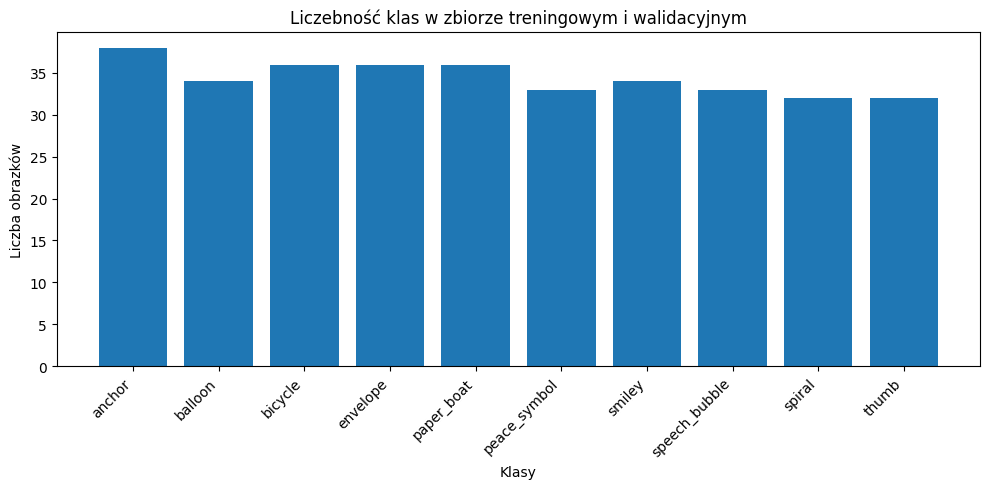

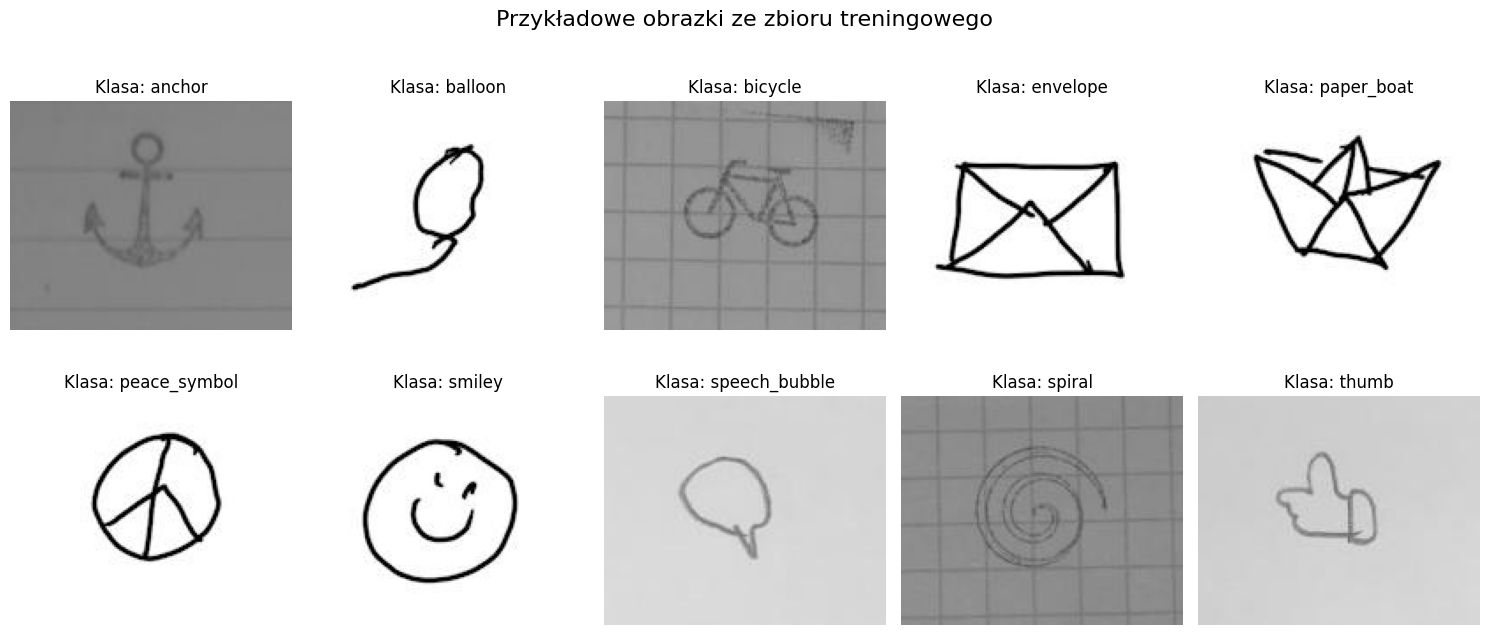

In [43]:
# dzielenie datasetu na train i test
train_val_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_val_size
train_val_ds, test_ds = torch.utils.data.random_split(full_ds, [train_val_size, test_size])
train_val_targets = np.array(full_ds.targets)[train_val_ds.indices]


# badanie zrównoważenia klas w zbiorze treningowym
class_counter = collections.Counter(train_val_targets)

plt.figure(figsize=(10, 5))
plt.bar(class_counter.keys(), class_counter.values())
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.xlabel("Klasy")
plt.ylabel("Liczba obrazków")
plt.title("Liczebność klas w zbiorze treningowym i walidacyjnym")
plt.tight_layout()
plt.savefig("figures/liczebnosc-klas.png")
plt.show()

# wizualizacja zbioru treningowego
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle("Przykładowe obrazki ze zbioru treningowego", fontsize=16)
for i, class_name in enumerate(class_names):
    class_idx = full_ds.class_to_idx[class_name]
    target_ixs = np.where(train_val_targets == class_idx)[0]
    
    ix = random.choice(target_ixs)
    img, label = train_val_ds[ix]
    
    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(f"Klasa: {class_name}")
    ax.axis('off')

# zapisywanie wizualizacji
plt.tight_layout()
plt.savefig("figures/ds-wizualizacja.png")

**Wnioski z przeprowadzonej eksploracji danych** 

Jak widać na powyższym wykresie, zbiór treningowy jest stosunkowo dobrze zbalansowany. Liczba obrazków w poszczególnych klasach jest do siebie zbliżona, co jest korzystne dla procesu uczenia i zmniejsza ryzyko, że model będzie faworyzował klasy liczniejsze.

#### 2. Preprocessing 

W tym etapie surowe obrazki (w formacie PIL) zostaną przekształcone do postaci tensorów. Ponadto, przeprowadzimy normalizację, która polega na przeskalowaniu wartości pikseli tak, aby miały średnią równą 0 i odchylenie standardowe równe 1. Obliczymy średnią i odchylenie standardowe na podstawie zbioru treningowego, aby uniknąć wycieku informacji ze zbioru testowego.

In [4]:
calc_transform = torchvision.transforms.ToTensor()

train_val_ds_for_calc = torchvision.datasets.ImageFolder(root="data", transform=calc_transform)
train_val_ds_for_calc = torch.utils.data.Subset(train_val_ds_for_calc, train_val_ds.indices)

calc_loader = torch.utils.data.DataLoader(train_val_ds_for_calc, batch_size=64, num_workers=2)

mean = 0
std = 0
n_samples = 0

for images_batch, labels_batch in calc_loader:
    batch_samples = images_batch.size(0)
    images_flat = images_batch.view(batch_samples, images_batch.size(1), -1)
    mean += images_flat.mean(2).sum(0)
    std += images_flat.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Obliczone wartości dla zbioru treningowego:")
print(f"Średnia: {mean}")
print(f"Odchylenie standardowe: {std}")

Obliczone wartości dla zbioru treningowego:
Średnia: tensor([0.7579, 0.7579, 0.7579])
Odchylenie standardowe: tensor([0.1081, 0.1081, 0.1081])


Zdefiniujemy dwie różne ścieżki transformacji obrazów:

1.  **Transformacja standardowa (`transform_norm`):** Używana dla naszych własnych, prostych modeli CNN. Obejmuje konwersję do tensora i normalizację z wykorzystaniem obliczonych wcześniej statystyk.

2.  **Transformacja dla modelu pretrained (`transform_pretrained`):** Używana dla modelu ResNet18. Oprócz konwersji do tensora, obrazy są skalowane do rozmiaru 224x224, a normalizacja odbywa się z użyciem standardowych wartości dla zbioru ImageNet, na którym model był pierwotnie trenowany.
```

In [5]:
# normalizacja zbioru dla modelu 1 i 2
transform_norm = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=mean, std=std)])

# normalizacja zbioru dla modelu 3 (ResNet18)
transform_pretrained = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# tworzenie zbiorów dla modeli 1 i 2
full_ds_norm = torchvision.datasets.ImageFolder(root="data", transform=transform_norm)
train_val_ds_norm = torch.utils.data.Subset(full_ds_norm, train_val_ds.indices)
test_ds_norm = torch.utils.data.Subset(full_ds_norm, test_ds.indices)

# tworzenie zbiorów dla modelu 3 (ResNet18)
full_ds_pretrained = torchvision.datasets.ImageFolder(root="data", transform=transform_pretrained)
train_val_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, train_val_ds.indices)
test_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, test_ds.indices)

#### 3. Modele

W tej części zdefiniujemy, wytrenujemy i porównamy trzy różne architektury sieci konwolucyjnych, ponieważ są one standardem w problemach związanych z przetwarzaniem i klasyfikacją obrazów. Zaczniemy od prostego modelu CNN, następnie wprowadzimy ulepszenia w postaci batch normalization i dropoutu, a na końcu wykorzystamy architekturę ResNet18. Jako funkcję straty wybieramy `CrossEntropyLoss`, a jako optymalizator znany i lubiany - optymalizator `Adam`.

- **Model 1 (CNN1)**: Prosta sieć z trzema warstwami konwolucyjnymi, każda z nich jest połączona z warstwą max-pooling, a następnie z warstwą w pełni połączoną

In [6]:
# model 1
class CNN1(torch.nn.Module):

    def __init__(self, input_size, num_classes):
        super(CNN1, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        

        self.conv_block3 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=32, out_channels=40, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = torch.nn.Linear(40 * 16 * 20, num_classes)

    def forward(self, x):

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x
    
model1 = CNN1(input_size=3,num_classes=len(class_names))

# optimizer hyperparameters
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

* **Model 2 (CNN2):** To rozbudowana wersja pierwszego. Do każdego bloku konwolucyjnego dodajemy warstwę `BatchNorm2d`, która stabilizuje i przyspiesza proces uczenia. Przed warstwą klasyfikującą dodajemy również warstwę `Dropout` z prawdopodobieństwem 0.5

In [7]:
# model 2
class CNN2(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN2, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(48 * 16 * 20, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

model2 = CNN2(input_size=3, num_classes=len(class_names))

# optimizer hyperparameters
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

* **Model 3:** Trzecie podejście to transfer learning. Wykorzystujemy wytrenowany wcześniej model ResNet18. "Zamrażamy" wagi wszystkich warstw konwolucyjnych, aby zachować wiedzę zdobytą na ImageNet, a następnie zastępujemy oryginalną warstwę klasyfikującą nową, dostosowaną do naszego problemu (10 klas).

In [8]:
# model 3
model3 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

for param in model3.parameters():
    param.requires_grad = False

num_ftrs = model3.fc.in_features
model3.fc = torch.nn.Linear(num_ftrs, num_classes)

optimizer3 = torch.optim.Adam(model3.fc.parameters(), lr=0.001)

In [9]:
epochs = 30
criterion = torch.nn.CrossEntropyLoss()

val_size = int(0.2 * len(train_val_ds))
train_size = len(train_val_ds) - val_size

# tworzenie loaderów dla modeli 1 i 2
train_ds_norm, val_ds_norm = torch.utils.data.random_split(train_val_ds_norm, [train_size, val_size])
train_loader_norm = torch.utils.data.DataLoader(train_ds_norm, batch_size=64, shuffle=True, num_workers=0)
val_loader_norm = torch.utils.data.DataLoader(val_ds_norm, batch_size=64, shuffle=False, num_workers=0)
test_loader_norm = torch.utils.data.DataLoader(test_ds_norm, batch_size=64, shuffle=False)

# tworzenie loaderów dla modelu 3 (ResNet18)
train_ds_pretrained, val_ds_pretrained = torch.utils.data.random_split(train_val_ds_pretrained, [train_size, val_size])
train_loader_pretrained = torch.utils.data.DataLoader(train_ds_pretrained, batch_size=64, shuffle=True, num_workers=0)
val_loader_pretrained = torch.utils.data.DataLoader(val_ds_pretrained, batch_size=64, shuffle=False, num_workers=0)
test_loader_pretrained = torch.utils.data.DataLoader(test_ds_pretrained, batch_size=64, shuffle=False)


print(f"Wielkość zbioru treningowego: {len(train_ds_norm)}")
print(f"Wielkość zbioru walidacyjnego: {len(val_ds_norm)}")
print(f"Wielkość zbioru testowego: {len(test_ds_norm)}")


Wielkość zbioru treningowego: 276
Wielkość zbioru walidacyjnego: 68
Wielkość zbioru testowego: 87


In [10]:
# training loop model 1
for epoch in range(epochs):
    model1.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

100%|██████████| 2/2 [00:00<00:00, 15.83it/s]


Epoch [1/30], Train Loss: 2.4040, Val Loss: 2.2976


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]


Epoch [2/30], Train Loss: 1.9772, Val Loss: 2.0023


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]


Epoch [3/30], Train Loss: 1.4988, Val Loss: 1.5304


100%|██████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch [4/30], Train Loss: 1.0854, Val Loss: 1.1759


100%|██████████| 2/2 [00:00<00:00, 18.42it/s]


Epoch [5/30], Train Loss: 0.9334, Val Loss: 0.9845


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


Epoch [6/30], Train Loss: 0.8254, Val Loss: 0.7374


100%|██████████| 2/2 [00:00<00:00, 18.44it/s]


Epoch [7/30], Train Loss: 0.6385, Val Loss: 0.6317


100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


Epoch [8/30], Train Loss: 0.5626, Val Loss: 0.4253


100%|██████████| 2/2 [00:00<00:00, 18.64it/s]


Epoch [9/30], Train Loss: 0.3810, Val Loss: 0.4500


100%|██████████| 2/2 [00:00<00:00, 18.11it/s]


Epoch [10/30], Train Loss: 0.3155, Val Loss: 0.3032


100%|██████████| 2/2 [00:00<00:00, 18.45it/s]


Epoch [11/30], Train Loss: 0.2476, Val Loss: 0.5821


100%|██████████| 2/2 [00:00<00:00, 18.14it/s]


Epoch [12/30], Train Loss: 0.2751, Val Loss: 0.3150


100%|██████████| 2/2 [00:00<00:00, 18.54it/s]


Epoch [13/30], Train Loss: 0.2070, Val Loss: 0.5003


100%|██████████| 2/2 [00:00<00:00, 18.37it/s]


Epoch [14/30], Train Loss: 0.2807, Val Loss: 0.3230


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch [15/30], Train Loss: 0.2001, Val Loss: 0.4293


100%|██████████| 2/2 [00:00<00:00, 18.16it/s]


Epoch [16/30], Train Loss: 0.2010, Val Loss: 0.2827


100%|██████████| 2/2 [00:00<00:00, 18.20it/s]


Epoch [17/30], Train Loss: 0.1186, Val Loss: 0.2276


100%|██████████| 2/2 [00:00<00:00, 18.48it/s]


Epoch [18/30], Train Loss: 0.0764, Val Loss: 0.3856


100%|██████████| 2/2 [00:00<00:00, 19.33it/s]


Epoch [19/30], Train Loss: 0.1030, Val Loss: 0.2850


100%|██████████| 2/2 [00:00<00:00, 17.07it/s]


Epoch [20/30], Train Loss: 0.0720, Val Loss: 0.3506


100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


Epoch [21/30], Train Loss: 0.0507, Val Loss: 0.1589


100%|██████████| 2/2 [00:00<00:00, 18.82it/s]


Epoch [22/30], Train Loss: 0.0480, Val Loss: 0.2217


100%|██████████| 2/2 [00:00<00:00, 18.47it/s]


Epoch [23/30], Train Loss: 0.0472, Val Loss: 0.2095


100%|██████████| 2/2 [00:00<00:00, 18.35it/s]


Epoch [24/30], Train Loss: 0.0256, Val Loss: 0.2803


100%|██████████| 2/2 [00:00<00:00, 18.36it/s]


Epoch [25/30], Train Loss: 0.0675, Val Loss: 0.2825


100%|██████████| 2/2 [00:00<00:00, 18.73it/s]


Epoch [26/30], Train Loss: 0.0548, Val Loss: 0.2360


100%|██████████| 2/2 [00:00<00:00, 18.26it/s]


Epoch [27/30], Train Loss: 0.0327, Val Loss: 0.1710


100%|██████████| 2/2 [00:00<00:00, 18.16it/s]


Epoch [28/30], Train Loss: 0.0336, Val Loss: 0.1641


100%|██████████| 2/2 [00:00<00:00, 18.12it/s]


Epoch [29/30], Train Loss: 0.0157, Val Loss: 0.1742


100%|██████████| 2/2 [00:00<00:00, 18.91it/s]

Epoch [30/30], Train Loss: 0.0113, Val Loss: 0.1555


In [11]:
# training loop model 2
for epoch in range(epochs):
    model2.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")



100%|██████████| 2/2 [00:00<00:00, 16.92it/s]


Epoch [1/30], Train Loss: 4.1158, Val Loss: 1.8628


100%|██████████| 2/2 [00:00<00:00, 16.88it/s]


Epoch [2/30], Train Loss: 2.1283, Val Loss: 1.8393


100%|██████████| 2/2 [00:00<00:00, 17.82it/s]


Epoch [3/30], Train Loss: 1.2735, Val Loss: 1.9069


100%|██████████| 2/2 [00:00<00:00, 16.66it/s]


Epoch [4/30], Train Loss: 0.9136, Val Loss: 1.4756


100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch [5/30], Train Loss: 0.7728, Val Loss: 1.2234


100%|██████████| 2/2 [00:00<00:00, 17.83it/s]


Epoch [6/30], Train Loss: 0.5426, Val Loss: 0.8197


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


Epoch [7/30], Train Loss: 0.4851, Val Loss: 0.6177


100%|██████████| 2/2 [00:00<00:00, 16.84it/s]


Epoch [8/30], Train Loss: 0.3721, Val Loss: 0.6993


100%|██████████| 2/2 [00:00<00:00, 17.08it/s]


Epoch [9/30], Train Loss: 0.3067, Val Loss: 0.4904


100%|██████████| 2/2 [00:00<00:00, 17.03it/s]


Epoch [10/30], Train Loss: 0.2476, Val Loss: 0.4193


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]


Epoch [11/30], Train Loss: 0.2543, Val Loss: 0.3520


100%|██████████| 2/2 [00:00<00:00, 16.80it/s]


Epoch [12/30], Train Loss: 0.1702, Val Loss: 0.3199


100%|██████████| 2/2 [00:00<00:00, 16.58it/s]


Epoch [13/30], Train Loss: 0.1841, Val Loss: 0.3031


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


Epoch [14/30], Train Loss: 0.1376, Val Loss: 0.2863


100%|██████████| 2/2 [00:00<00:00, 16.77it/s]


Epoch [15/30], Train Loss: 0.1529, Val Loss: 0.3176


100%|██████████| 2/2 [00:00<00:00, 17.47it/s]


Epoch [16/30], Train Loss: 0.1166, Val Loss: 0.2972


100%|██████████| 2/2 [00:00<00:00, 16.86it/s]


Epoch [17/30], Train Loss: 0.1066, Val Loss: 0.2783


100%|██████████| 2/2 [00:00<00:00, 17.08it/s]


Epoch [18/30], Train Loss: 0.0785, Val Loss: 0.4444


100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch [19/30], Train Loss: 0.0688, Val Loss: 0.4466


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]


Epoch [20/30], Train Loss: 0.0551, Val Loss: 0.3271


100%|██████████| 2/2 [00:00<00:00, 17.18it/s]


Epoch [21/30], Train Loss: 0.0453, Val Loss: 0.3943


100%|██████████| 2/2 [00:00<00:00, 16.74it/s]


Epoch [22/30], Train Loss: 0.0420, Val Loss: 0.5881


100%|██████████| 2/2 [00:00<00:00, 16.82it/s]


Epoch [23/30], Train Loss: 0.0417, Val Loss: 0.4528


100%|██████████| 2/2 [00:00<00:00, 16.98it/s]


Epoch [24/30], Train Loss: 0.0383, Val Loss: 0.3418


100%|██████████| 2/2 [00:00<00:00, 17.01it/s]


Epoch [25/30], Train Loss: 0.0331, Val Loss: 0.3672


100%|██████████| 2/2 [00:00<00:00, 16.98it/s]


Epoch [26/30], Train Loss: 0.0269, Val Loss: 0.6545


100%|██████████| 2/2 [00:00<00:00, 16.78it/s]


Epoch [27/30], Train Loss: 0.0234, Val Loss: 0.4638


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]


Epoch [28/30], Train Loss: 0.0190, Val Loss: 0.5364


100%|██████████| 2/2 [00:00<00:00, 17.54it/s]


Epoch [29/30], Train Loss: 0.0197, Val Loss: 0.6443


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]

Epoch [30/30], Train Loss: 0.0158, Val Loss: 0.6665


In [12]:
# training loop model 3
epochs = 30
for epoch in range(epochs):
    model3.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_pretrained):
        outputs = model3(images)
        loss = criterion(outputs, labels)

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        train_loss += loss.item()
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_pretrained):
            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_pretrained):.4f}, Val Loss: {val_loss/len(val_loader_pretrained):.4f}")

100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch [1/30], Train Loss: 2.4094, Val Loss: 2.1420


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch [2/30], Train Loss: 2.0321, Val Loss: 1.9493


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Epoch [3/30], Train Loss: 1.7448, Val Loss: 1.7403


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Epoch [4/30], Train Loss: 1.4822, Val Loss: 1.5321


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch [5/30], Train Loss: 1.2770, Val Loss: 1.3775


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch [6/30], Train Loss: 1.0796, Val Loss: 1.2022


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Epoch [7/30], Train Loss: 0.9707, Val Loss: 1.0634


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch [8/30], Train Loss: 0.8337, Val Loss: 0.9441


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Epoch [9/30], Train Loss: 0.7294, Val Loss: 0.8466


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch [10/30], Train Loss: 0.6567, Val Loss: 0.7442


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch [11/30], Train Loss: 0.5634, Val Loss: 0.6336


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch [12/30], Train Loss: 0.5364, Val Loss: 0.5376


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Epoch [13/30], Train Loss: 0.4820, Val Loss: 0.4874


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Epoch [14/30], Train Loss: 0.4435, Val Loss: 0.4483


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Epoch [15/30], Train Loss: 0.4144, Val Loss: 0.3940


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Epoch [16/30], Train Loss: 0.3878, Val Loss: 0.3780


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch [17/30], Train Loss: 0.3554, Val Loss: 0.3685


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch [18/30], Train Loss: 0.3415, Val Loss: 0.3586


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Epoch [19/30], Train Loss: 0.3005, Val Loss: 0.3280


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch [20/30], Train Loss: 0.2869, Val Loss: 0.3071


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Epoch [21/30], Train Loss: 0.2687, Val Loss: 0.2967


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Epoch [22/30], Train Loss: 0.2678, Val Loss: 0.2840


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch [23/30], Train Loss: 0.2446, Val Loss: 0.2864


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch [24/30], Train Loss: 0.2438, Val Loss: 0.2631


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch [25/30], Train Loss: 0.2253, Val Loss: 0.2557


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch [26/30], Train Loss: 0.2066, Val Loss: 0.2433


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch [27/30], Train Loss: 0.1955, Val Loss: 0.2391


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch [28/30], Train Loss: 0.1859, Val Loss: 0.2281


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch [29/30], Train Loss: 0.1875, Val Loss: 0.2135


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

Epoch [30/30], Train Loss: 0.1709, Val Loss: 0.2113


#### 4. Ewaluacja modeli

Na tym etapie oceniamy ostateczną skuteczność modeli na zbiorze testowym. Celem jest weryfikacja, jak dobrze modele generalizują wiedzę na nowe dane.

Wybrane metryki:

*   **Raport klasyfikacji:** zamiast samej dokładności (Accuracy), analizujemy też inne metryki:
    *   **Precision**
    *   **Recall**
    *   **F1-Score**

*   **Confusion matrix:** pokazuje, które klasy są ze sobą najczęściej mylone

In [92]:
def evaluate_model(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print(f"--- Ewaluacja dla: {model_name} ---")
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nRaport klasyfikacji:")
    print(report)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidziana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.title(f'Confusion matrix dla {model_name}')
    plt.savefig(f"figures/{model_name.replace(" ", "_").lower()}.png")
    plt.show()

--- Ewaluacja dla: Model 1 (CNN1) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      0.92      0.96        12
      balloon       1.00      0.50      0.67         6
      bicycle       0.67      0.80      0.73         5
     envelope       0.90      1.00      0.95         9
   paper_boat       1.00      0.88      0.93         8
 peace_symbol       0.78      0.88      0.82         8
       smiley       0.92      0.85      0.88        13
speech_bubble       0.89      1.00      0.94         8
       spiral       0.60      0.86      0.71         7
        thumb       0.90      0.82      0.86        11

     accuracy                           0.86        87
    macro avg       0.86      0.85      0.84        87
 weighted avg       0.88      0.86      0.86        87



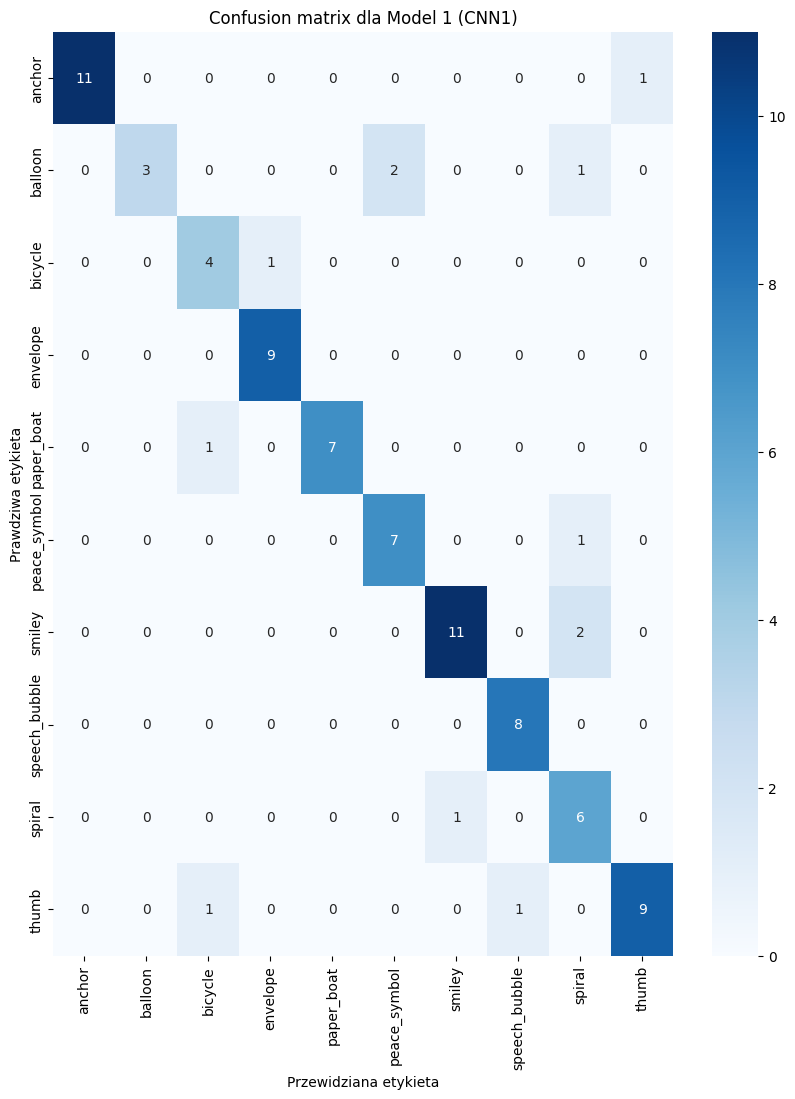

--- Ewaluacja dla: Model 2 (CNN2) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        12
      balloon       1.00      0.50      0.67         6
      bicycle       0.83      1.00      0.91         5
     envelope       1.00      1.00      1.00         9
   paper_boat       1.00      0.88      0.93         8
 peace_symbol       0.70      0.88      0.78         8
       smiley       1.00      0.85      0.92        13
speech_bubble       0.89      1.00      0.94         8
       spiral       0.70      1.00      0.82         7
        thumb       1.00      0.91      0.95        11

     accuracy                           0.91        87
    macro avg       0.91      0.90      0.89        87
 weighted avg       0.93      0.91      0.91        87



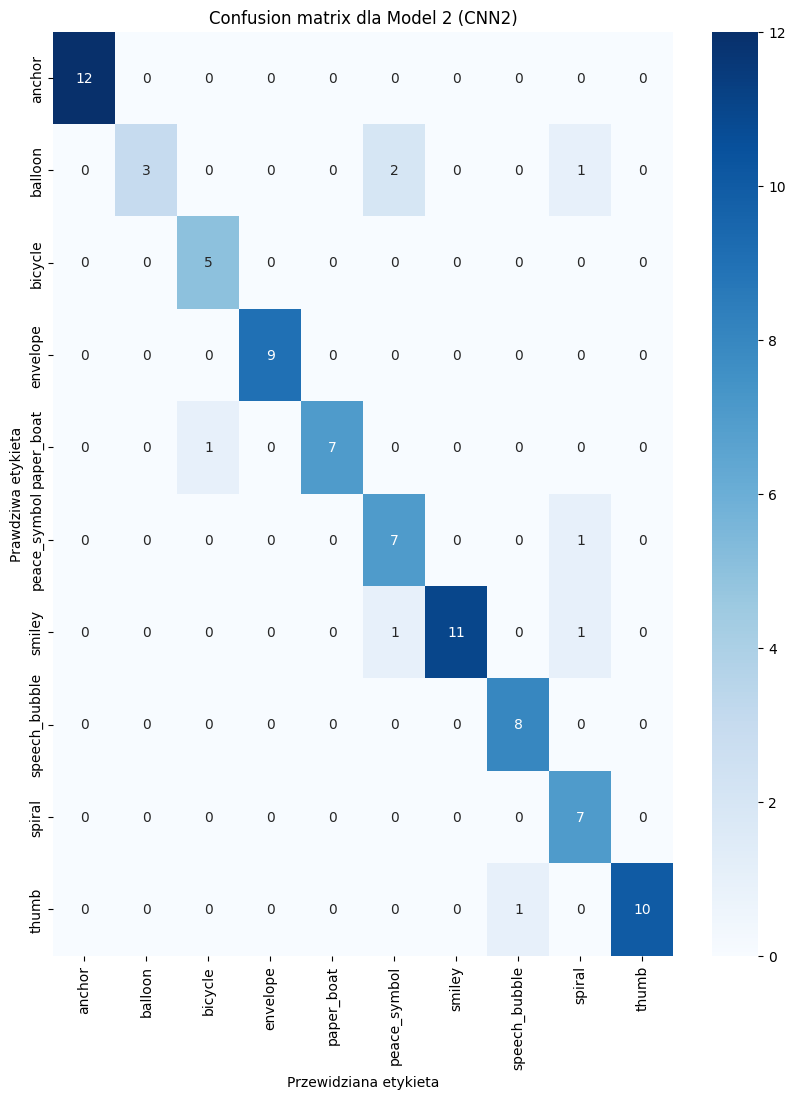

--- Ewaluacja dla: Model 3 (ResNet18) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       0.92      1.00      0.96        12
      balloon       0.62      0.83      0.71         6
      bicycle       1.00      1.00      1.00         5
     envelope       1.00      0.89      0.94         9
   paper_boat       0.89      1.00      0.94         8
 peace_symbol       1.00      1.00      1.00         8
       smiley       1.00      1.00      1.00        13
speech_bubble       1.00      0.75      0.86         8
       spiral       1.00      1.00      1.00         7
        thumb       1.00      0.91      0.95        11

     accuracy                           0.94        87
    macro avg       0.94      0.94      0.94        87
 weighted avg       0.95      0.94      0.94        87



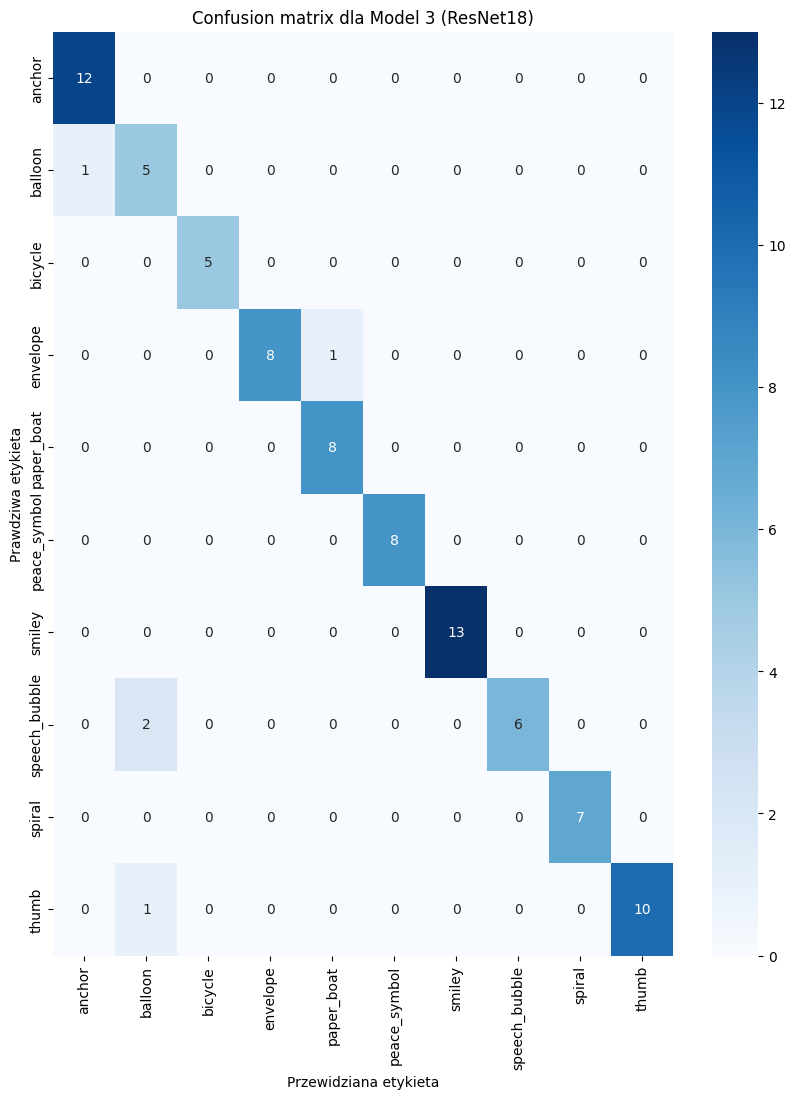

In [93]:
# ewaluacja modeli
evaluate_model(model1, test_loader_norm, "Model 1 (CNN1)")
evaluate_model(model2, test_loader_norm, "Model 2 (CNN2)")
evaluate_model(model3, test_loader_pretrained, "Model 3 (ResNet18)")

**Wyniki pokazały wyraźną progresję:**
* Prosty model CNN1 stanowił solidną bazę, ale miał trudności z niektórymi klasami
* Ulepszony CNN2 z batch normalization i dropoutem wykazał znaczącą poprawę
* Model oparty o transfer learning (ResNet18) okazał się zdecydowanie najskuteczniejszy, osiągając niemal bezbłędne wyniki i deklasując modele trenowane od zera

**Analiza Błędów**
* **Błędy modeli:** Słabością prostszych architektur było mylenie klas o podobnych cechach wizualnych (np. smiley, speech_bubble, spiral), co było widoczne na ich macierzach pomyłek. Model ResNet18 niemal całkowicie wyeliminował te problemy
* **Wyciek danych:** Początkowo prawdopodobnie niepoprawne podzielenie i użycie datasetu, co mogło doprowadzić do wycieku danych

**Miejsca do poprawy**

Chociaż osiągnięto bardzo dobre wyniki, istnieją dalsze możliwości progresji:
* **Augmentacja danych:** Zastosowanie technik takich jak losowe obroty czy zmiany jasności mogłoby jeszcze bardziej zwiększyć odporność modelu, nawet tego najlepszego
* **Eksperymenty z hiperparametrami:** Można by przetestować inne optymalizatory, wartości współczynnika uczenia czy większą liczbę epok treningowych

### Augmentacja danych
Ponownie wytrenujemy **Model 2 (CNN2)** na zbiorze z augmentacją. Wybraliśmy ten model, ponieważ jego wyniki nie były idealne, co stwarza przestrzeń do widocznej poprawy


In [15]:
# transformacja z augmentacją dla zbioru treningowego i walidacyjnego
transform_with_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# zbiór testowy pozostawiamy bez augmentacji
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [16]:
full_ds_with_aug = torchvision.datasets.ImageFolder(root="data", transform=transform_with_aug)
train_val_ds_with_aug = torch.utils.data.Subset(full_ds_with_aug, train_val_ds.indices)

# zbiór treningowy z augmentacją, walidaycjny i testowy pozostają takie same
train_ds_aug, _ = torch.utils.data.random_split(train_val_ds_with_aug, [train_size, val_size])

# tworzymy nowy loader
train_loader_aug = torch.utils.data.DataLoader(train_ds_aug, batch_size=64, shuffle=True, num_workers=0)

print(f"Nowy zbiór treningowy (z augmentacją): {len(train_ds_aug)} obrazków")

Nowy zbiór treningowy (z augmentacją): 276 obrazków


In [17]:
model2_aug = CNN2(input_size=3, num_classes=len(class_names))
optimizer2_aug = torch.optim.Adam(model2_aug.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30

for epoch in range(epochs):
    model2_aug.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_aug):
        outputs = model2_aug(images)
        loss = criterion(outputs, labels)

        optimizer2_aug.zero_grad()
        loss.backward()
        optimizer2_aug.step()
        train_loss += loss.item()

    model2_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2_aug(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_aug):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

100%|██████████| 2/2 [00:00<00:00, 15.81it/s]


Epoch [1/30], Train Loss: 4.5739, Val Loss: 2.5404


100%|██████████| 2/2 [00:00<00:00, 16.92it/s]


Epoch [2/30], Train Loss: 3.4402, Val Loss: 2.2956


100%|██████████| 2/2 [00:00<00:00, 16.54it/s]


Epoch [3/30], Train Loss: 2.2481, Val Loss: 1.8351


100%|██████████| 2/2 [00:00<00:00, 14.60it/s]


Epoch [4/30], Train Loss: 1.6386, Val Loss: 1.9764


100%|██████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch [5/30], Train Loss: 1.4787, Val Loss: 1.3309


100%|██████████| 2/2 [00:00<00:00, 16.75it/s]


Epoch [6/30], Train Loss: 1.2533, Val Loss: 0.9345


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


Epoch [7/30], Train Loss: 1.0430, Val Loss: 1.0982


100%|██████████| 2/2 [00:00<00:00, 15.00it/s]


Epoch [8/30], Train Loss: 0.9270, Val Loss: 0.8802


100%|██████████| 2/2 [00:00<00:00, 16.80it/s]


Epoch [9/30], Train Loss: 0.8237, Val Loss: 0.8806


100%|██████████| 2/2 [00:00<00:00, 16.91it/s]


Epoch [10/30], Train Loss: 0.7867, Val Loss: 0.7542


100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


Epoch [11/30], Train Loss: 0.8037, Val Loss: 0.6452


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


Epoch [12/30], Train Loss: 0.7213, Val Loss: 0.5575


100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Epoch [13/30], Train Loss: 0.7572, Val Loss: 0.5673


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch [14/30], Train Loss: 0.5774, Val Loss: 0.4946


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


Epoch [15/30], Train Loss: 0.5526, Val Loss: 0.4407


100%|██████████| 2/2 [00:00<00:00, 15.78it/s]


Epoch [16/30], Train Loss: 0.5508, Val Loss: 0.5617


100%|██████████| 2/2 [00:00<00:00, 15.92it/s]


Epoch [17/30], Train Loss: 0.4562, Val Loss: 0.5030


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


Epoch [18/30], Train Loss: 0.4369, Val Loss: 0.4506


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]


Epoch [19/30], Train Loss: 0.4524, Val Loss: 0.2452


100%|██████████| 2/2 [00:00<00:00, 16.42it/s]


Epoch [20/30], Train Loss: 0.4873, Val Loss: 0.3008


100%|██████████| 2/2 [00:00<00:00, 15.79it/s]


Epoch [21/30], Train Loss: 0.3953, Val Loss: 0.3314


100%|██████████| 2/2 [00:00<00:00, 15.61it/s]


Epoch [22/30], Train Loss: 0.4412, Val Loss: 0.2388


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Epoch [23/30], Train Loss: 0.3389, Val Loss: 0.5006


100%|██████████| 2/2 [00:00<00:00, 16.63it/s]


Epoch [24/30], Train Loss: 0.2762, Val Loss: 0.2497


100%|██████████| 2/2 [00:00<00:00, 16.88it/s]


Epoch [25/30], Train Loss: 0.3253, Val Loss: 0.3122


100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


Epoch [26/30], Train Loss: 0.3240, Val Loss: 0.1684


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]


Epoch [27/30], Train Loss: 0.2240, Val Loss: 0.1796


100%|██████████| 2/2 [00:00<00:00, 15.91it/s]


Epoch [28/30], Train Loss: 0.2954, Val Loss: 0.2176


100%|██████████| 2/2 [00:00<00:00, 15.96it/s]


Epoch [29/30], Train Loss: 0.2955, Val Loss: 0.1452


100%|██████████| 2/2 [00:00<00:00, 16.43it/s]

Epoch [30/30], Train Loss: 0.1971, Val Loss: 0.1629


--- Ewaluacja dla: Model 2 (CNN2) z augmentacją ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        12
      balloon       1.00      0.67      0.80         6
      bicycle       0.83      1.00      0.91         5
     envelope       1.00      1.00      1.00         9
   paper_boat       1.00      1.00      1.00         8
 peace_symbol       1.00      1.00      1.00         8
       smiley       0.87      1.00      0.93        13
speech_bubble       0.80      1.00      0.89         8
       spiral       1.00      0.57      0.73         7
        thumb       1.00      1.00      1.00        11

     accuracy                           0.94        87
    macro avg       0.95      0.92      0.93        87
 weighted avg       0.95      0.94      0.94        87



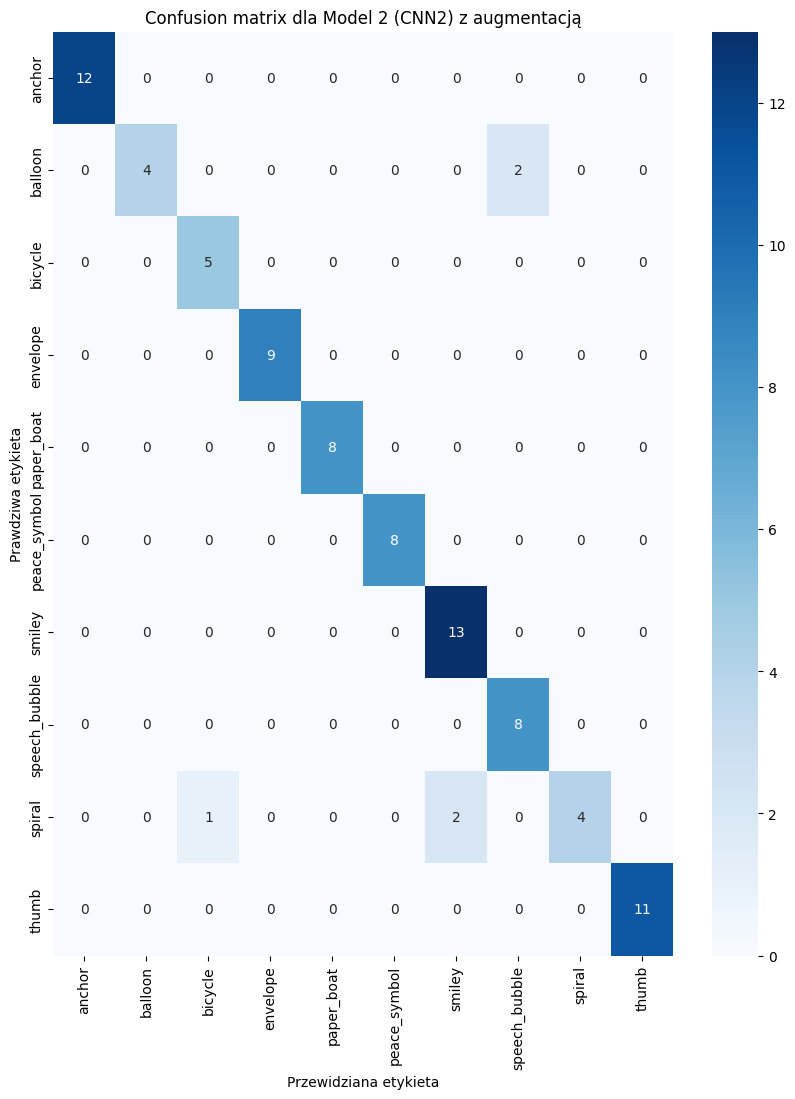

In [94]:
evaluate_model(model2_aug, test_loader_norm, "Model 2 (CNN2) z augmentacją")

Na podstawie przedstawionych wyników można wyciągnąć następujące wnioski:
* **Poprawa skuteczności:** Zastosowanie augmentacji danych przyniosło wyraźną poprawę we wszystkich kluczowych metrykach
* **Lepsza generalizacja:** Średni ważony F1-score podskoczył, co wskazuje, że model lepiej radzi sobie z klasyfikacją wszystkich kategorii, a nie tylko tych najłatwiejszych
* **Naprawa słabych punktów:** Augmentacja szczególnie pomogła w klasach, z którymi model miał największy problem, na przykład skuteczność dla klasy spiral oraz smiley wzrosła

Eksperyment pokazuje, że augmentacja danych jest skuteczną techniką dla tego zbioru danych. Zwiększenie różnorodności obrazów treningowych pozwoliło modelowi lepiej generalizować na nowe dane.

### Activation maps (Grad-CAM)

Grad-CAM pozwala ona na stworzenie "mapy ciepła", która wizualizuje, które obszary na obrazie były dla modelu najważniejsze podczas klasyfikacji. Innymi słowy, możemy zobaczyć, na czym model "skupia swoją uwagę".

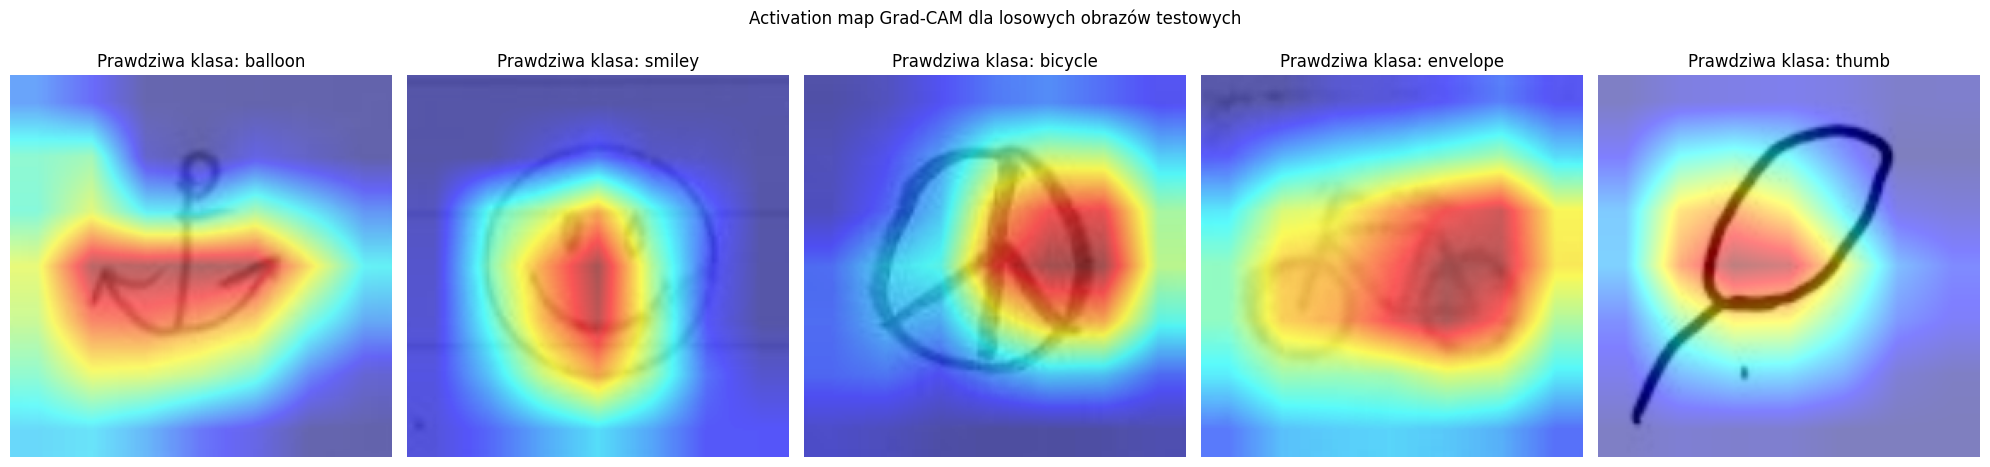

In [73]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model_to_vis = model3
target_layer = [model_to_vis.layer4[-1].conv2]
n_img_to_show = 5

for param in model_to_vis.parameters():
    param.requires_grad = True

cam = GradCAM(model=model_to_vis, target_layers=target_layer)

fig, axes = plt.subplots(1, n_img_to_show, figsize=(20, 5))
fig.suptitle("Activation map Grad-CAM dla losowych obrazów testowych")

resize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224)
])

random_indices = np.random.choice(len(test_ds), n_img_to_show, replace=False)

for i, idx in enumerate(random_indices):
    input_tensor, label_idx = test_ds_pretrained[idx]
    original_pil_img, _ = test_ds[idx]

    input_tensor_batch = input_tensor.unsqueeze(0)
    targets = [ClassifierOutputTarget(label_idx)]

    grayscale_cam = cam(input_tensor=input_tensor_batch, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    resized_pil_img = resize_transform(original_pil_img)
    rgb_img_float = np.array(resized_pil_img) / 255.0

    visualization = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

    ax = axes[i]
    ax.imshow(visualization)
    ax.set_title(f"Prawdziwa klasa: {class_names[label_idx]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("figures/activation-maps.png")
plt.show()

Na podstawie wygenerowanych map aktywacji można wyciągnąć następujące wnioski:

* **Model nauczył się poprawnych cech:** Wizualizacje pokazują, że model w większości przypadków skupia swoją uwagę na charakterystycznych i istotnych częściach rysunku, a nie na tle czy przypadkowych elementach, na przykład dla klasy smiley aktywacja koncentruje się na oczach i uśmiechu
* **Potwierdzenie wysokiej skuteczności:** Taka interpretowalność daje nam pewność, że wysoka dokładność modelu nie jest dziełem przypadku, model nie nauczył się jakichś nieistotnych korelacji (np. koloru tła), ale faktycznie rozpoznaje kluczowe cechy obiektów na rysunkach
* **Potencjalne słabości:** W niektórych przypadkach (np. speech_bubble czy anchor) aktywacje są mniej precyzyjne i rozproszone. Może to sugerować, że cechy tych obiektów są mniej jednoznaczne, ale mimo to model był w stanie dokonać poprawnej klasyfikacji

In [20]:
torch.save(model3.state_dict(), 'resnet18.pth')